Num GPUs Available:  1


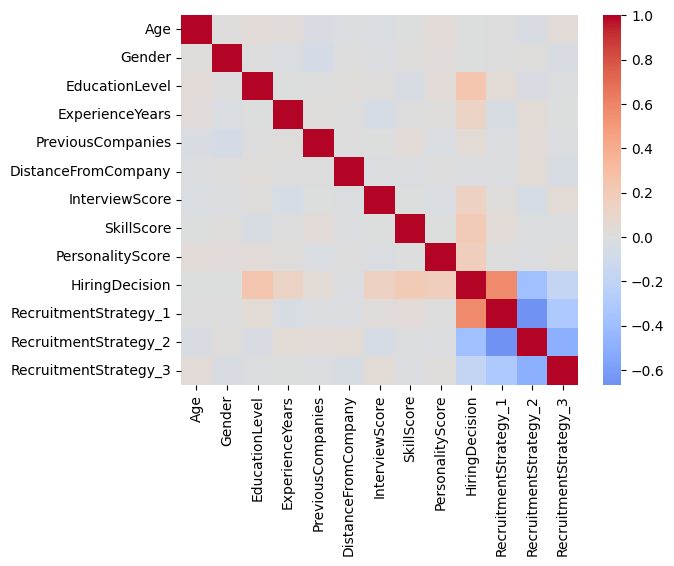

In [8]:
import numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import seaborn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import scipy

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

recrutamento = pd.read_csv('recruitment_data.csv', sep=',', decimal='.')

# Instanciando o objeto One-Hot encoder, pois vai ser utilizada na coluna recrutamento Strategy
ohe = OneHotEncoder(handle_unknown='ignore')
# Fazendo a transformação
ohe_df = pd.DataFrame(ohe.fit_transform(recrutamento[['RecruitmentStrategy']]).toarray(), columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3'])

# Agrupando a nova coluna com o df original
df = recrutamento.join(ohe_df)

recrutamento = df.drop(['RecruitmentStrategy'], axis=1)


corrPearson = recrutamento.corr('pearson')

seaborn.heatmap(corrPearson, annot=False, cmap='coolwarm', center=0)

features = list(recrutamento.columns.values)

classificacao = 'HiringDecision'

corrKendall = recrutamento.corr('kendall')

corrPearson = recrutamento.corr('pearson')

corrSpearman = recrutamento.corr('spearman')

tabela_correlacoes = pd.DataFrame()

tabela_correlacoes['kendal']= corrKendall['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['pearson']= corrPearson['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['spearman']= corrSpearman['HiringDecision'].sort_values(ascending=False)

tabela_correlacoes.drop(tabela_correlacoes[tabela_correlacoes['kendal']==1].index, inplace=True)

tabela_correlacoes

#Verifica-se que a estrategia de recrutamento  =1 que eh a agressiva, vai impactar muito na decisao final de contratacao

#removendo as features que tiveram indice de correlacao menor que 0.1
#tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

features.remove('PreviousCompanies')
features.remove('Age')
features.remove('Gender')
features.remove('DistanceFromCompany')

#Remove o output
features.remove(classificacao)

X = recrutamento[features].to_numpy() 
Y = recrutamento[classificacao].to_numpy() 



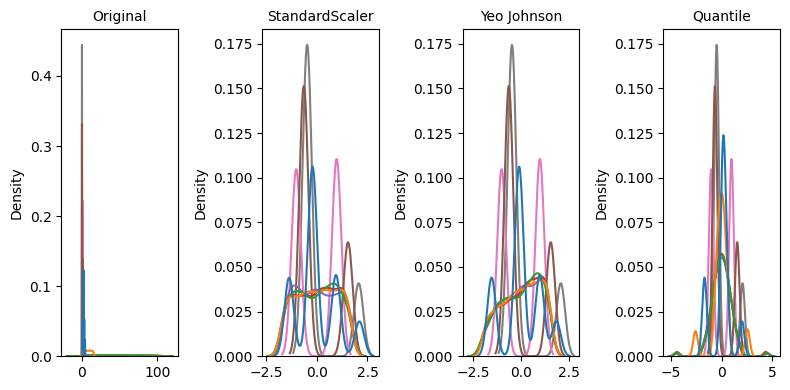

In [9]:
import matplotlib.pyplot as plt
STANDARD_SCALER = StandardScaler()
X_normalizado_standard = STANDARD_SCALER.fit_transform(X)


MIN_MAX_SCALER = MinMaxScaler(feature_range=(0, 1))
X_normalizado_min_max = MIN_MAX_SCALER.fit_transform(X)


X_transformado_std= X_normalizado_standard


from sklearn.preprocessing import PowerTransformer, QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')


pt = PowerTransformer(method='yeo-johnson')
# X_new= pd.DataFrame()
# for feature in features:
#   x_ranked = (scipy.stats.rankdata(recrutamento[feature])/(X.shape[0]+1)-.5)*2
#   X_new[feature] = numpy.arctanh(x_ranked)

  # or 'box-cox' for positive data


teste_yeo_johnson = pt.fit_transform(X)
teste_yeo_johnson = STANDARD_SCALER.fit_transform(teste_yeo_johnson)

teste_quantile = qt.fit_transform(X)
teste_quantile = STANDARD_SCALER.fit_transform(teste_quantile)


f, axs = plt.subplots(1, 4, figsize=(8, 4))
seaborn.kdeplot(X, ax=axs[0], legend=False,)
axs[0].set_title('Original', size=10)

seaborn.kdeplot(X_transformado_std, ax=axs[1], legend=False,)
axs[1].set_title('StandardScaler', size=10)

seaborn.kdeplot(teste_yeo_johnson, ax=axs[2], legend=False)
axs[2].set_title('Yeo Johnson', size=10)

seaborn.kdeplot(teste_quantile, ax=axs[3], legend=False)
axs[3].set_title('Quantile', size=10)

f.tight_layout()

X_transformado = teste_quantile




In [10]:
# PARAMETROS DA REDE 
maximo_neuronios = 5
funcoes_ativacao = ['tanh', 'relu'] 
metrica = 'Accuracy' 
#quantidade de loops q vai esperar ate q o erro de teste comece a aumentar 
paciencia = 150
max_epocas =3*paciencia
min_improvement = 0.01
adam_initial_lr = 0.01
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True #se comecar o erro a subir, volta pra onde tava bom

# SEED que controla a aleatoriedade 
random_seed = 22
n_k_folds = 5 #quantas partes o dataset vai ser dividido

tf.random.set_seed(random_seed)
#keras.utils.set_random_seed(random_seed)
# DIVIDE EM K PEDACOS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_transformado, Y)

5

In [12]:
#Testando com KerasClassifier
def create_model(neurons, activation='relu'):
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_shape=(X_transformado.shape[1],),  activation=activation))
    #model.add(tf.keras.layers.Dense(neurons*2, input_shape=(X_transformado.shape[1],),  activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

tf.random.set_seed(random_seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
neurons = [X_transformado.shape[1], X_transformado.shape[1]*2]
epochs = [1500]
param_grid = dict(epochs=epochs, model__neurons=neurons, model__activation=funcoes_ativacao)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_transformado, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.924667 using {'epochs': 1500, 'model__activation': 'tanh', 'model__neurons': 16}
0.922000 (0.066953) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__neurons': 8}
0.924667 (0.072498) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__neurons': 16}
0.856667 (0.065727) with: {'epochs': 1500, 'model__activation': 'relu', 'model__neurons': 8}
0.869333 (0.059007) with: {'epochs': 1500, 'model__activation': 'relu', 'model__neurons': 16}


In [30]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

y_predict = grid_result.best_estimator_.predict(X_teste)

from sklearn.metrics import ConfusionMatrixDisplay
fig = ConfusionMatrixDisplay.from_predictions(y_teste, y_predict , display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title(grid_result.best_score_, grid_result.best_params_)
plt.show()


Acurácia: 0.9222222222222223
Precisão: 0.921875
Recall: 0.8251748251748252
Especificidade: 0.9674267100977199
F1 Score: 0.8708487084870848
ROC AUC Score: 0.9222113391494497


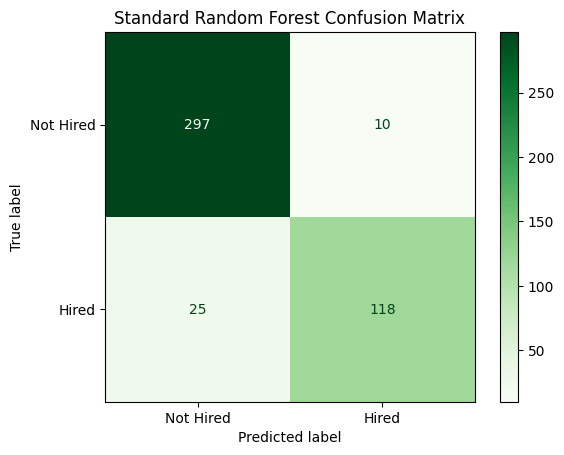

In [25]:

#IMPLEMENTANDO O RANDOMFOREST SEM BALANCEAMENTO
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)
# Criação do modelo e treinamento
# Funciona por meio de votação, ou seja, a classe que tiver mais votos é a classe que o modelo vai escolher
floresta = RandomForestClassifier(n_estimators = 100)
floresta.fit(X_treinamento, y_treinamento)

previsoes = floresta.predict(X_teste)

# Os valores percentuais da previsão
# predict_proba retorna a probabilidade de cada classe, o primeiro valor é a probabilidade de ser 0 e o segundo de ser 1
previsoes_percent = floresta.predict_proba(X_teste)
# As probabilidades de 1, usaremos para a função ROC
previsoes_percent = previsoes_percent[:,1]
previsoes_percent


matriz_confusao = confusion_matrix(y_teste, previsoes)
matriz_confusao

# Acurácia
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia:", accuracy)

# Precisão
precision = precision_score(y_teste, previsoes)
print("Precisão:", precision)

# Recall
recall = recall_score(y_teste, previsoes)
print("Recall:", recall)

# Especificidade.
tn, fp, fn, tp = confusion_matrix(y_teste, previsoes).ravel()
specificity = tn / (tn + fp)
print("Especificidade:", specificity)

# F1 Score
f1 = f1_score(y_teste, previsoes)
print("F1 Score:", f1)

# ROC AUC Score (necessita das probabilidades de classe em vez de previsões).
# Para calcular a ROC AUC é necessário passar a probabilidade de ser 1.
roc_auc = roc_auc_score(y_teste, previsoes_percent)
print("ROC AUC Score:", roc_auc)

fig = ConfusionMatrixDisplay.from_estimator(floresta, X_teste, y_teste, display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()



Mean accuracy: 0.942
Mean recall: 0.916
Mean precision: 0.967


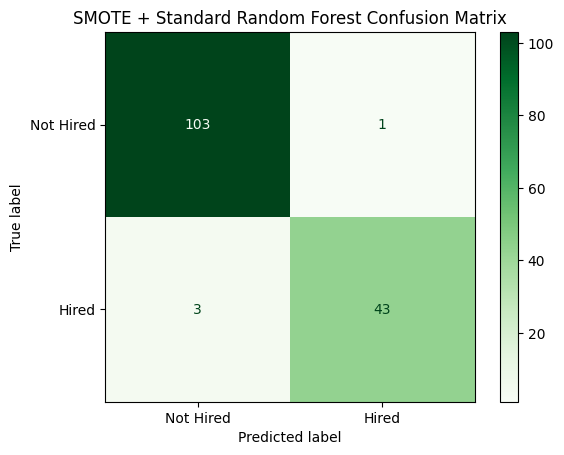

In [23]:
#RANDOM FOREST COM SMOTE (BALANCEAMENTO)
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_transformado, Y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean accuracy: %.3f' % mean(scores['test_accuracy']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X_transformado, Y, test_size=0.1, stratify=Y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = ConfusionMatrixDisplay.from_estimator(SMOTE_SRF, X_test, y_test, display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()



In [ ]:
# TREINANDO
metric_lower_bound = 0.0
metric_median = 0.0
resultados = []
for n_neuron in numpy.arange(1, maximo_neuronios+1):
    ix_fold = 1
    #divisao os grupos de treino e teste, ele faz pelos indices
    for train_index, test_index in sk_folds.split(X_transformado, Y):
        # pegar o dado do teste  e treino   a partir dos indices da divisao feita pelo skfolds
        X_train, X_test = X_transformado[train_index], X_transformado[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        for funcao_ativacao in funcoes_ativacao : 
            #configurando o otimizador 
            optimizer = tf.keras.optimizers.Adam( learning_rate=adam_initial_lr, 
                                                    beta_1=adam_lr_decay ) 
            
            # Configurando a rede
            model_name = f"ADAM-N{n_neuron}F{ix_fold}_{classificacao}_{funcao_ativacao}"
            val_metric_name = f'val_{metrica}'
            
            inputs = tf.keras.Input(shape=(X_transformado.shape[1], ))        
            hidden = tf.keras.layers.Dense(n_neuron, activation=funcao_ativacao)(inputs)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden) #penas 1 classificacao = 1 saida
            rede = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)

            #Usar o otimizador com erro medio quadratico 
            rede.compile(optimizer=optimizer, loss='mse', metrics=[metrica])
            
            #early stop com foco no erro do grupo de validacao
            es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, restore_best_weights=True)
            #early stop com foco na acuracia dos testes
            es_metric = tf.keras.callbacks.EarlyStopping(monitor=metrica, mode='max', patience=paciencia, min_delta=min_improvement, restore_best_weights=True)


            #iniciando a rede para tentar encontrar o modelo
            resultado = rede.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                    epochs=max_epocas, verbose=0, callbacks=[es_loss, es_metric], )

        

            # RESULTADOS DA REDE
            model_loss = resultado.history['loss'][-1]
            model_val_loss = resultado.history['val_loss'][-1]
            metric_val = resultado.history[metrica][-1]
            val_metric_val = resultado.history[val_metric_name][-1]
            n_epochs = len(resultado.history['val_loss'])

            resultado_dict = {'model_name': model_name,
                            'optimizer': optimizer,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            metrica: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': rede,
                            'history': resultado}
            resultados.append(resultado_dict)

            print(f"{model_name} > epochs: {n_epochs} loss: {model_loss} val_loss: {model_val_loss} {metrica}: {100.0*metric_val}% {val_metric_name}: {100.0*val_metric_val}%")
                

            # SE CHEGAR NO 100% para de aumentar 
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break

            print('')
        ix_fold += 1
        
    # GET LOWER BOUND OF WINNING ALGORITHM
    df_resultados = pd.DataFrame(resultados)


In [ ]:
resultado_resumido = pd.DataFrame()

lista_dict = []
for qtde_neuronio in numpy.arange(1, maximo_neuronios+1):
    for funcao_ativacao in funcoes_ativacao:
        filtrado = df_resultados[(df_resultados['neurons']==qtde_neuronio) & (df_resultados['model_name'].str.contains(funcao_ativacao))]
        temp_dict ={}
        temp_dict['neuronios'] = qtde_neuronio
        temp_dict['ativacao'] = funcao_ativacao
        temp_dict[f'{metrica}_media'] =  filtrado.loc[:, metrica].mean()
        stringVal = f'val_{metrica}'
        temp_dict[f'{stringVal}_media'] =  filtrado.loc[:, stringVal].mean()
        temp_dict[f'epocas_media'] =  filtrado.loc[:, 'epochs'].mean()
        temp_dict[f'val_loss_media'] =  filtrado.loc[:, 'val_loss'].mean()
        temp_dict[f'loss_media'] =  filtrado.loc[:, 'loss'].mean()
        lista_dict.append(temp_dict)
        

resultado_resumido = pd.DataFrame(lista_dict)
resultado_resumido.sort_values(by=f'{metrica}_media', ascending=False)